
# **Name: Sajan Arora**
# **Movie Ticket Reservation system**

In [ ]:
pip install mysql-connector-python

### Database Setup (SQL)

In [25]:
import mysql.connector

# Establishing connection
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='boston123'
)

cursor = conn.cursor()

# SQL Script
sql_script = """
CREATE DATABASE IF NOT EXISTS MovieReservation;
USE MovieReservation;

CREATE TABLE IF NOT EXISTS Users (
    user_id INT PRIMARY KEY AUTO_INCREMENT,
    name VARCHAR(50),
    email VARCHAR(100) UNIQUE
);

CREATE TABLE IF NOT EXISTS UserRoles (
    role_id INT PRIMARY KEY AUTO_INCREMENT,
    role_name VARCHAR(50) NOT NULL
);

CREATE TABLE IF NOT EXISTS Logs (
    log_id INT PRIMARY KEY AUTO_INCREMENT,
    action VARCHAR(255),
    user_id INT,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES Users(user_id)
);

CREATE TABLE IF NOT EXISTS Movies (
    movie_id INT PRIMARY KEY AUTO_INCREMENT,
    title VARCHAR(100),
    release_date DATE
);

CREATE TABLE IF NOT EXISTS Genres (
    genre_id INT PRIMARY KEY AUTO_INCREMENT,
    genre_name VARCHAR(50) NOT NULL
);

CREATE TABLE IF NOT EXISTS MovieGenres (
    movie_id INT,
    genre_id INT,
    PRIMARY KEY (movie_id, genre_id),
    FOREIGN KEY (movie_id) REFERENCES Movies(movie_id),
    FOREIGN KEY (genre_id) REFERENCES Genres(genre_id)
);

CREATE TABLE IF NOT EXISTS Showtimes (
    showtime_id INT PRIMARY KEY AUTO_INCREMENT,
    movie_id INT,
    start_time DATETIME,
    FOREIGN KEY (movie_id) REFERENCES Movies(movie_id)
);

CREATE TABLE IF NOT EXISTS Reservations (
    reservation_id INT PRIMARY KEY AUTO_INCREMENT,
    user_id INT,
    showtime_id INT,
    booking_status VARCHAR(20),
    booking_date DATETIME,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (showtime_id) REFERENCES Showtimes(showtime_id)
);

CREATE TABLE IF NOT EXISTS Payments (
    payment_id INT PRIMARY KEY AUTO_INCREMENT,
    reservation_id INT,
    amount DECIMAL(10, 2),
    payment_status VARCHAR(20),
    payment_date DATETIME,
    FOREIGN KEY (reservation_id) REFERENCES Reservations(reservation_id)
);

CREATE TABLE IF NOT EXISTS Ratings (
    rating_id INT PRIMARY KEY AUTO_INCREMENT,
    user_id INT,
    movie_id INT,
    rating_score INT CHECK (rating_score BETWEEN 1 AND 5),
    rating_date DATETIME,
    FOREIGN KEY (user_id) REFERENCES Users(user_id),
    FOREIGN KEY (movie_id) REFERENCES Movies(movie_id)
);

CREATE TABLE IF NOT EXISTS Revenue (
    revenue_id INT PRIMARY KEY AUTO_INCREMENT,
    movie_id INT,
    total_revenue DECIMAL(10, 2),
    FOREIGN KEY (movie_id) REFERENCES Movies(movie_id)
);
"""

# Executing SQL script
for statement in sql_script.split(';'):
    if statement.strip():
        cursor.execute(statement)

print("Database and tables created successfully.")

# Closing the connection
cursor.close()
conn.close()


Database and tables created successfully.


### Tables Schema

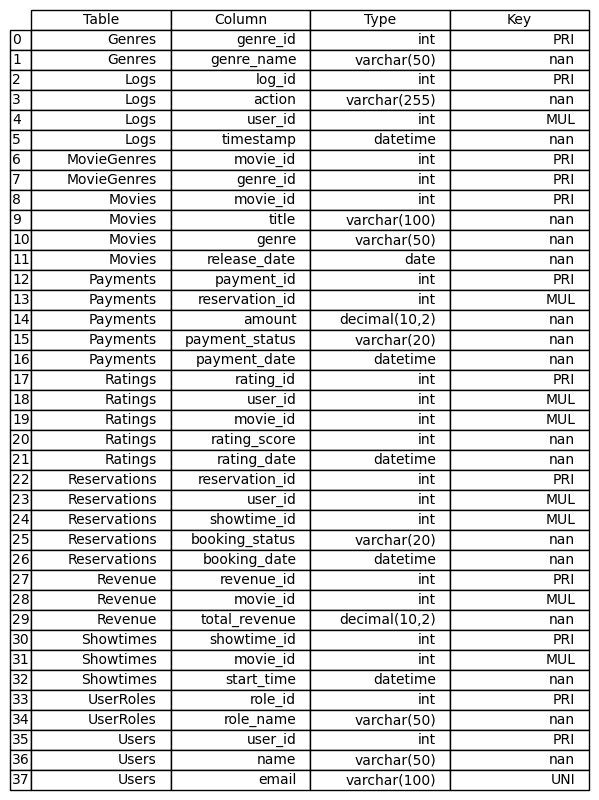

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

schema_df = pd.read_csv("movie_reservation_schema.csv") 

# Selecting relevant columns for display
schema_df = schema_df[['Table', 'Column', 'Type', 'Key']]

# Setting up Matplotlib figure
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.axis('tight')
ax.axis('off')

# Creating a table and add it to the Matplotlib figure
schema_table = table(ax, schema_df, loc='center', colWidths=[0.25] * len(schema_df.columns))
schema_table.auto_set_font_size(False)
schema_table.set_fontsize(10)
schema_table.scale(1.2, 1.2) 

# Saving the table as an image
plt.savefig("schema_table1.png", dpi=300, bbox_inches='tight')
plt.show()


### Python Code for Database Interaction & Admin Module

In [27]:
# importing mysql.connector
from contextlib import contextmanager
import pandas as pd

# Database connection context manager
@contextmanager
def connect_db():
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='boston123',
        database='MovieReservation'
    )
    try:
        yield conn
    finally:
        conn.close()
# Fetching data from the database
with connect_db() as conn:
    query = """
        SELECT 
            r.reservation_id,
            r.user_id,
            r.showtime_id,
            r.booking_status,
            r.booking_date,
            s.start_time AS showtime_start,
            m.title AS movie_title,
            m.genre AS movie_genre,
            m.release_date AS movie_release_date,
            rt.rating_score
        FROM Reservations r
        LEFT JOIN Showtimes s ON r.showtime_id = s.showtime_id
        LEFT JOIN Movies m ON s.movie_id = m.movie_id
        LEFT JOIN Ratings rt ON m.movie_id = rt.movie_id AND r.user_id = rt.user_id
    """
# Manually fetching data and convert to DataFrame
with connect_db() as conn:
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  
    processed_df = pd.DataFrame(rows, columns=columns)


# Admin functions for managing movies
def add_movie(title, genre, release_date):
    with connect_db() as conn:
        cursor = conn.cursor()
        cursor.execute(
            "INSERT INTO Movies (title, genre, release_date) VALUES (%s, %s, %s)",
            (title, genre, release_date)
        )
        conn.commit()
        print(f"Movie '{title}' added successfully.")

def update_movie(movie_id, title, genre, release_date):
    with connect_db() as conn:
        cursor = conn.cursor()
        cursor.execute(
            "UPDATE Movies SET title=%s, genre=%s, release_date=%s WHERE movie_id=%s",
            (title, genre, release_date, movie_id)
        )
        conn.commit()
        print(f"Movie with ID {movie_id} updated successfully.")

def delete_movie(movie_id):
    with connect_db() as conn:
        cursor = conn.cursor()
        cursor.execute(
            "DELETE FROM Movies WHERE movie_id=%s", (movie_id,)
        )
        conn.commit()
        print(f"Movie with ID {movie_id} deleted successfully.")
 
# Admin functions for managing showtimes
def add_showtime(movie_id, start_time):
    with connect_db() as conn:
        cursor = conn.cursor()
        cursor.execute(
            "INSERT INTO Showtimes (movie_id, start_time) VALUES (%s, %s)",
            (movie_id, start_time)
        )
        conn.commit()
        print(f"Showtime added successfully for Movie ID {movie_id}.")


def admin_menu():
    while True:
        print("\nAdmin Menu:")
        print("1. Add Movie")
        print("2. Update Movie")
        print("3. Delete Movie")
        print("4. Add Showtime")
        print("5. Exit")
        choice = input("Enter your choice: ")

        if choice == '1':
            title = input("Enter Movie Title: ")
            genre = input("Enter Genre: ")
            release_date = input("Enter Release Date (YYYY-MM-DD): ")
            add_movie(title, genre, release_date)
        elif choice == '2':
            movie_id = int(input("Enter Movie ID to update: "))
            title = input("Enter New Title: ")
            genre = input("Enter New Genre: ")
            release_date = input("Enter New Release Date (YYYY-MM-DD): ")
            update_movie(movie_id, title, genre, release_date)
        elif choice == '3':
            movie_id = int(input("Enter Movie ID to delete: "))
            delete_movie(movie_id)
        elif choice == '4':
            movie_id = int(input("Enter Movie ID: "))
            start_time = input("Enter Showtime Start Time (YYYY-MM-DD HH:MM:SS): ")
            add_showtime(movie_id, start_time)
        elif choice == '5':
            print("Exiting Admin Menu...")
            break
        else:
            print("Invalid choice. Please try again.")

# Main user interaction menu
def menu():
    while True:
        print("\nMenu:")
        print("1. View Movies")
        print("2. Book Reservation")
        print("3. Admin Menu")
        print("4. Exit")
        choice = input("Enter your choice: ")

        if choice == '1':
            view_movies()
        elif choice == '2':
            user_id = int(input("Enter Your User ID: "))  
            print("\nAvailable Movies and Showtimes:")
            # Displaying movies and showtimes
            view_movies()  
            showtime_id = int(input("Enter Showtime ID to book: ")) 
            book_reservation(user_id, showtime_id)  
        elif choice == '3':
            admin_menu()
        elif choice == '4':
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please try again.")

def view_movies():
    with connect_db() as conn:
        cursor = conn.cursor()
        cursor.execute("""
            SELECT m.movie_id, m.title, m.genre, m.release_date, s.showtime_id, s.start_time
            FROM Movies m
            LEFT JOIN Showtimes s ON m.movie_id = s.movie_id
            WHERE s.showtime_id IS NOT NULL  -- Exclude movies without showtimes
            ORDER BY m.movie_id, s.start_time
        """)
        movies = cursor.fetchall()
        print("\nMovies and Showtimes:")
        for movie in movies:
            print(f"Movie ID: {movie[0]}, Title: {movie[1]}, Genre: {movie[2]}, Release Date: {movie[3]}, "
                  f"Showtime ID: {movie[4]}, Showtime: {movie[5]}")
        cursor.close()



def book_reservation(user_id, showtime_id):
    with connect_db() as conn:
        cursor = conn.cursor()
        # Validating the showtime ID
        cursor.execute("SELECT * FROM Showtimes WHERE showtime_id = %s", (showtime_id,))
        showtime = cursor.fetchone()
        if not showtime:
            print("\nInvalid Showtime ID. Please try again.")
            return
        # Proceed with booking
        cursor.execute(
            "INSERT INTO Reservations (user_id, showtime_id, booking_status, booking_date) VALUES (%s, %s, %s, NOW())",
            (user_id, showtime_id, 'Confirmed')
        )
        conn.commit()
        print("\nReservation booked successfully!")
menu()



Menu:
1. View Movies
2. Book Reservation
3. Admin Menu
4. Exit


Enter your choice:  1



Movies and Showtimes:
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 1, Showtime: 2024-10-25 14:00:00
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 1855, Showtime: 2024-12-03 08:16:37
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 2735, Showtime: 2024-12-03 11:43:25
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 13, Showtime: 2024-12-04 04:20:54
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 8725, Showtime: 2024-12-04 04:53:55
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 332, Showtime: 2024-12-04 12:44:55
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 7900, Showtime: 2024-12-04 13:51:02
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 7901, Showtime: 2024-12-05 03:51:02
Movie ID: 1, Title: Movie A, Ge

Enter your choice:  2
Enter Your User ID:  11



Available Movies and Showtimes:

Movies and Showtimes:
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 1, Showtime: 2024-10-25 14:00:00
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 1855, Showtime: 2024-12-03 08:16:37
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 2735, Showtime: 2024-12-03 11:43:25
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 13, Showtime: 2024-12-04 04:20:54
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 8725, Showtime: 2024-12-04 04:53:55
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 332, Showtime: 2024-12-04 12:44:55
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 7900, Showtime: 2024-12-04 13:51:02
Movie ID: 1, Title: Movie A, Genre: Action, Release Date: 2024-01-15, Showtime ID: 7901, Showtime: 2024-12-05 03:51:0

Enter Showtime ID to book:  11



Reservation booked successfully!

Menu:
1. View Movies
2. Book Reservation
3. Admin Menu
4. Exit


Enter your choice:  4


Exiting...


### Simulated Data Generation

In [29]:
from faker import Faker
from random import choice, randint
from datetime import datetime, timedelta
import numpy as np
import mysql.connector

# Initializing Faker
fake = Faker()

# Connecting to the database
def connect_db():
    return mysql.connector.connect(
        host='localhost',
        user='root',
        password='boston123', 
        database='MovieReservation'
    )

with connect_db() as conn:
    cursor = conn.cursor()

    # Populating Genres Table
    genres = ['Action', 'Comedy', 'Drama', 'Horror', 'Sci-Fi', 'Romance']
    for genre in genres:
        cursor.execute("INSERT IGNORE INTO Genres (genre_name) VALUES (%s)", (genre,))

    # Fetching all genre IDs
    cursor.execute("SELECT genre_id FROM Genres")
    genre_ids = [row[0] for row in cursor.fetchall()]

    # Populating Movies and MovieGenres
    for _ in range(50):  
        title = fake.catch_phrase()
        release_date = fake.date_between(start_date='-5y', end_date='today')
        cursor.execute("INSERT INTO Movies (title, release_date) VALUES (%s, %s)", (title, release_date))
        movie_id = cursor.lastrowid

    # Assigning 1-3 random genres to each movie
    for genre_id in np.random.choice(genre_ids, size=randint(1, 3), replace=False):
        cursor.execute(
            "INSERT INTO MovieGenres (movie_id, genre_id) VALUES (%s, %s)",
            (movie_id, int(genre_id))  
        )

    # Generating 100 Users
    for _ in range(100):
        name = fake.name()
        email = fake.unique.email()
        cursor.execute("INSERT INTO Users (name, email) VALUES (%s, %s)", (name, email))

    # Fetching all user IDs
    cursor.execute("SELECT user_id FROM Users")
    user_ids = [row[0] for row in cursor.fetchall()]

    # Generating Showtimes for Movies
    cursor.execute("SELECT movie_id FROM Movies")
    movie_ids = [row[0] for row in cursor.fetchall()]

    for movie_id in movie_ids:
        for _ in range(randint(1, 3)):  
            start_time = datetime.now() + timedelta(days=randint(1, 30), hours=randint(8, 20))
            cursor.execute("INSERT INTO Showtimes (movie_id, start_time) VALUES (%s, %s)", (movie_id, start_time))

    # Fetching all showtime IDs
    cursor.execute("SELECT showtime_id FROM Showtimes")
    showtime_ids = [row[0] for row in cursor.fetchall()]

    # Generate Reservations
    for _ in range(500): 
        user_id = choice(user_ids)
        showtime_id = choice(showtime_ids)
        booking_status = choice(['Confirmed', 'Cancelled'])
        booking_date = datetime.now() - timedelta(days=randint(1, 30))
        cursor.execute(
            "INSERT INTO Reservations (user_id, showtime_id, booking_status, booking_date) VALUES (%s, %s, %s, %s)",
            (user_id, showtime_id, booking_status, booking_date)
        )

    # Populating Revenue Table
    for movie_id in movie_ids:
        total_revenue = np.random.randint(100000, 1000000)  # Random revenue for each movie
        cursor.execute("INSERT INTO Revenue (movie_id, total_revenue) VALUES (%s, %s)", (movie_id, total_revenue))

    # Simulating Logs
    # Generating 100 log entries
    for _ in range(100):  
        user_id = choice(user_ids)
        action = choice(['User Login', 'Reservation Made', 'Payment Completed'])
        cursor.execute("INSERT INTO Logs (user_id, action) VALUES (%s, %s)", (user_id, action))

    # Commit changes
    conn.commit()
    print("Simulated data inserted successfully.")


Simulated data inserted successfully.


### Sample Data From Tables

In [30]:
import pandas as pd

# Function to fetch data from a table
def fetch_table_data(table_name, limit=5):
    with connect_db() as conn:
        query = f"SELECT * FROM {table_name} LIMIT {limit};"
        return pd.read_sql(query, conn)

tables = ["Genres", "Movies", "Users", "Showtimes", "Reservations", "Revenue", "Logs"]

for table in tables:
    print(f"Sample data from {table}:")
    print(fetch_table_data(table).to_string(index=False))
    print("\n")


Sample data from Genres:
 genre_id genre_name
       55     Action
       56     Comedy
       57      Drama
       58     Horror
       59     Sci-Fi


Sample data from Movies:
 movie_id   title    genre release_date
        1 Movie A   Action   2024-01-15
        2 Movie B   Comedy   2024-02-10
        3 Movie C    Drama   2024-03-05
        4 Movie D Thriller   2024-04-12
        5 Movie E  Romance   2024-05-01


Sample data from Users:
 user_id          name                     email
       1      John Doe      john.doe@example.com
       2    Jane Smith    jane.smith@example.com
       3 Alice Johnson alice.johnson@example.com
       4  Bob Williams  bob.williams@example.com
       5 Charlie Brown charlie.brown@example.com


Sample data from Showtimes:
 showtime_id  movie_id          start_time
           1         1 2024-10-25 14:00:00
           2         2 2024-10-25 16:00:00
           3         3 2024-10-25 18:00:00
           4         4 2024-10-25 20:00:00
           5     

/var/folders/qp/nh4_m7bd58d2x9rjjxdz06kc0000gn/T/ipykernel_87467/3960364201.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/var/folders/qp/nh4_m7bd58d2x9rjjxdz06kc0000gn/T/ipykernel_87467/3960364201.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/var/folders/qp/nh4_m7bd58d2x9rjjxdz06kc0000gn/T/ipykernel_87467/3960364201.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/var/folders/qp/nh4_m7bd58d2x9rjjxdz06kc0000gn/T/

### Data Collection from TMDB API

In [31]:
import requests

# TMDB API configuration
api_key = '84cb34080dbb2ba1771bf69d067186d3'
url = f'https://api.themoviedb.org/3/movie/popular?api_key={api_key}&language=en-US&page=1'

# Fetching data from TMDB API
response = requests.get(url)

if response.status_code == 200:
    movies_data = response.json().get('results', [])
    print(f"Fetched {len(movies_data)} movies from TMDB API.")
else:
    print(f"Failed to fetch data from TMDB API. Status code: {response.status_code}")
    exit()

with connect_db() as conn:
    cursor = conn.cursor()
    if movies_data:
        inserted_count = 0
        for movie in movies_data:
            title = movie['title']
            genre = movie['genre_ids'][0] if movie['genre_ids'] else None
            release_date = movie['release_date']
            try:
                cursor.execute(
                    "INSERT INTO Movies (title, genre, release_date) VALUES (%s, %s, %s)",
                    (title, genre, release_date)
                )
                inserted_count += 1
            except mysql.connector.Error as err:
                print(f"Failed to insert movie '{title}': {err}")

        conn.commit()
        print(f"Inserted {inserted_count} movies into the Movies table.")
    else:
        print("No movies to insert.")


Fetched 20 movies from TMDB API.
Inserted 20 movies into the Movies table.


### Data Preprocessing 


In [32]:
import mysql.connector
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from contextlib import contextmanager

def preprocess_data(df):
    print("Preprocessing started...")

    # Handling Missing Data
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)

    # Removing Duplicates
    df.drop_duplicates(inplace=True)

    # Datetime Feature Engineering
    if 'booking_date' in df.columns:
        df['booking_month'] = pd.to_datetime(df['booking_date']).dt.month
        df['booking_weekday'] = pd.to_datetime(df['booking_date']).dt.weekday
    if 'showtime_start' in df.columns:
        df['showtime_hour'] = pd.to_datetime(df['showtime_start']).dt.hour

    # Target Encoding for Titles and Genres
    df['movie_title_encoded'] = df['movie_title'].astype('category').cat.codes
    df['movie_genre_encoded'] = df['movie_genre'].astype('category').cat.codes
    df['movie_release_year'] = pd.to_datetime(df['movie_release_date']).dt.year

    # Aggregate Features
    # Calculate user and movie total reservations
    if 'user_total_reservations' not in df.columns:
        df['user_total_reservations'] = df.groupby('user_id')['reservation_id'].transform('count')
    if 'movie_total_reservations' not in df.columns:
        df['movie_total_reservations'] = df.groupby('movie_title')['reservation_id'].transform('count')

    # Normalizing Numerical Data (Exclude IDs)
    scaler = MinMaxScaler()
    numerical_columns = ['booking_month', 'booking_weekday', 'showtime_hour', 'movie_release_year',
                         'user_total_reservations', 'movie_total_reservations']
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # Converting Booking Status to Binary
    df['booking_status'] = df['booking_status'].map({'Confirmed': 1, 'Cancelled': 0})

    print("Preprocessing complete!")
    return df


# Displaying the processed data
processed_df = preprocess_data(processed_df)
print("Processed Data:")
print(processed_df.head())

# Saving processed data
processed_df.to_csv('processed_data.csv', index=False)
print("Processed data saved to 'processed_data.csv'.")

Preprocessing started...
Preprocessing complete!
Processed Data:
   reservation_id  user_id  showtime_id  booking_status        booking_date  \
0               1        1            1               1 2024-10-23 10:00:00   
1               2        2            2               0 2024-10-23 11:00:00   
2               3        2            2               1 2024-10-24 10:58:06   
3               4        1            4               1 2024-10-23 13:00:00   
4               6        2            6               1 2024-10-23 15:00:00   

       showtime_start movie_title movie_genre movie_release_date  \
0 2024-10-25 14:00:00     Movie A      Action         2024-01-15   
1 2024-10-25 16:00:00     Movie B      Comedy         2024-02-10   
2 2024-10-25 16:00:00     Movie B      Comedy         2024-02-10   
3 2024-10-25 20:00:00     Movie D    Thriller         2024-04-12   
4 2024-10-26 16:30:00     Movie F      Horror         2024-06-15   

   rating_score  booking_month  booking_weekday  sh

### Machine Learning Models
### Baseline And Linear Regression Model


Baseline Model
Mean Squared Error: 4638.30
R-squared: 0.00
RMSE: 68.11

Linear Regression Model
Mean Squared Error (MSE): 2470.45
Root Mean Squared Error (RMSE): 49.70
R-squared (R²): 0.47

--- Cross-Validation ---
Cross-Validation R² Scores: [-29.31606273  -2.34338616  -4.93595224  -4.19962352  -4.90742972]
Mean Cross-Validation R²: -9.14

--- Feature Importance ---
                    Feature  Coefficient
0   user_total_reservations   126.427788
1  movie_total_reservations   -56.737054
2             booking_month  -223.283886
3           booking_weekday    -1.964150


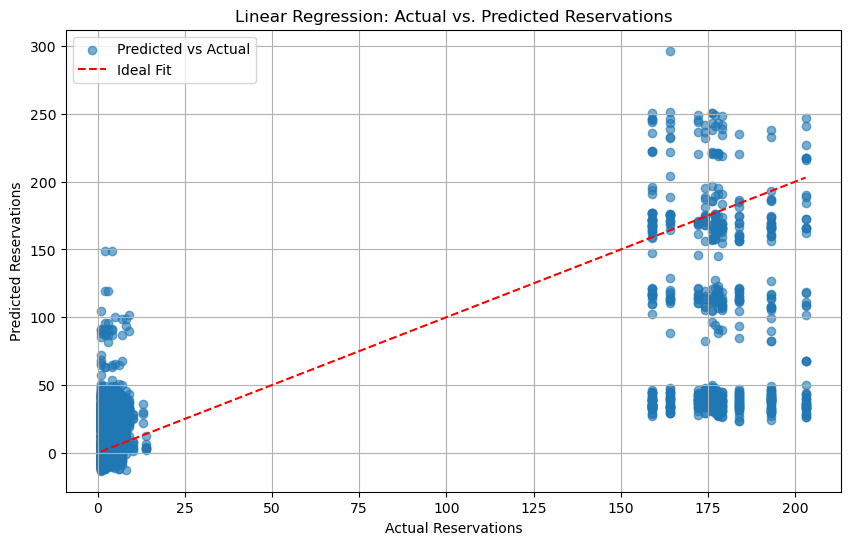


--- Residuals Analysis ---


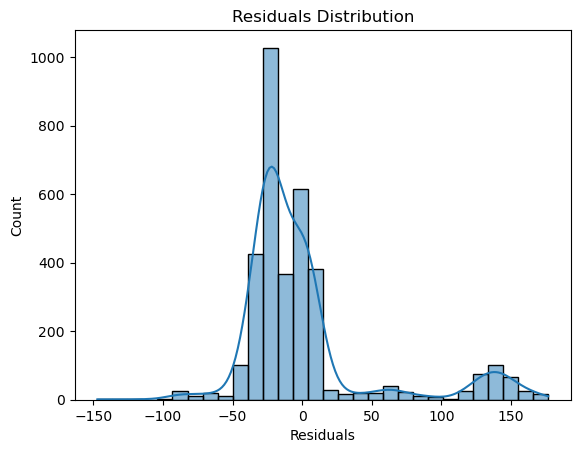

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring 'total_reservations' is calculated
if 'total_reservations' not in processed_df.columns:
    processed_df['total_reservations'] = (
        processed_df.groupby('showtime_id')['reservation_id'].transform('count')
    )

# Features and target
features = ['user_total_reservations', 'movie_total_reservations', 'booking_month', 'booking_weekday']
target = 'total_reservations'

# Verifying that features and target exist in processed_df
missing_features = [f for f in features if f not in processed_df.columns]
if missing_features:
    raise ValueError(f"Missing features in DataFrame: {missing_features}")
if target not in processed_df.columns:
    raise ValueError(f"Target '{target}' not found in DataFrame.")

X = processed_df[features]
y = processed_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Baseline Model
mean_baseline = np.mean(y_test)
baseline_predictions = [mean_baseline] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, baseline_predictions)
print("\nBaseline Model")
print(f"Mean Squared Error: {baseline_mse:.2f}")
print(f"R-squared: {baseline_r2:.2f}")
print(f"RMSE: {baseline_rmse:.2f}")

# Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Model")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Cross-validation
cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
print("\n--- Cross-Validation ---")
print("Cross-Validation R² Scores:", cv_scores)
print(f"Mean Cross-Validation R²: {cv_scores.mean():.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lin_reg.coef_
})
print("\n--- Feature Importance ---")
print(feature_importance)

# Actual vs. Predicted Reservations Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel('Actual Reservations')
plt.ylabel('Predicted Reservations')
plt.title('Linear Regression: Actual vs. Predicted Reservations')
plt.legend()
plt.grid(True)
plt.show()

# Residuals Analysis Plot
print("\n--- Residuals Analysis ---")
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()


### Decision Tree Classifier



Decision Tree Classifier
Accuracy: 0.73
RMSE (based on probabilities): 0.42

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.88      0.76      2010
           1       0.82      0.58      0.68      1993

    accuracy                           0.73      4003
   macro avg       0.75      0.73      0.72      4003
weighted avg       0.75      0.73      0.72      4003



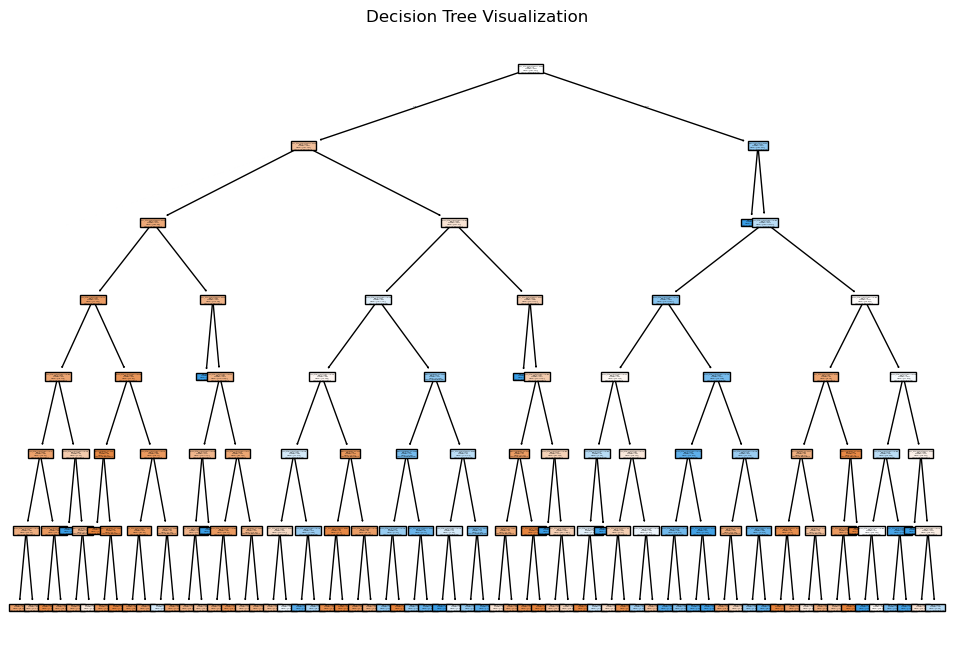

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report  
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Threshold to classify "high" vs "low" reservations
threshold = y.median()  
y_class = (y > threshold).astype(int)

# Resampling with SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_class)

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy'
)
grid_search.fit(X_train_clf, y_train_clf)

# Predictions and evaluation
best_clf = grid_search.best_estimator_
y_pred_clf = best_clf.predict(X_test_clf)
clf_accuracy = accuracy_score(y_test_clf, y_pred_clf)
clf_report = classification_report(y_test_clf, y_pred_clf)

# RMSE for Decision Tree (using probabilities)
y_pred_proba = best_clf.predict_proba(X_test_clf)[:, 1]
clf_rmse = np.sqrt(mean_squared_error(y_test_clf, y_pred_proba))

print("\nDecision Tree Classifier")
print(f"Accuracy: {clf_accuracy:.2f}")
print(f"RMSE (based on probabilities): {clf_rmse:.2f}")
print("\nClassification Report:\n", clf_report)

# Decision Tree Plot
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features, class_names=['Low Reservations', 'High Reservations'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

### Data Analysis and Visualization

Compact Summary Statistics:
                                 mean       median          std  min      max
reservation_id            6549.894200  6814.000000  3687.619770  1.0  12598.0
user_id                   1006.896880   707.000000   740.564450  1.0   3342.0
showtime_id               2730.613536  1961.000000  2959.472606  1.0  13722.0
booking_status               0.493474     0.000000     0.499979  0.0      1.0
rating_score                 4.579653     5.000000     0.780049  2.0      5.0
booking_month                0.630564     0.666667     0.124018  0.0      1.0
booking_weekday              0.516683     0.500000     0.328274  0.0      1.0
showtime_hour                0.461851     0.450000     0.242123  0.0      1.0
movie_title_encoded         28.210563    29.000000    17.223129  0.0     56.0
movie_genre_encoded          6.414383     5.000000     4.924564  0.0     20.0
movie_release_year           0.976489     1.000000     0.147002  0.0      1.0
user_total_reservations      0.12157

/var/folders/qp/nh4_m7bd58d2x9rjjxdz06kc0000gn/T/ipykernel_87467/399395524.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = processed_df.corr()


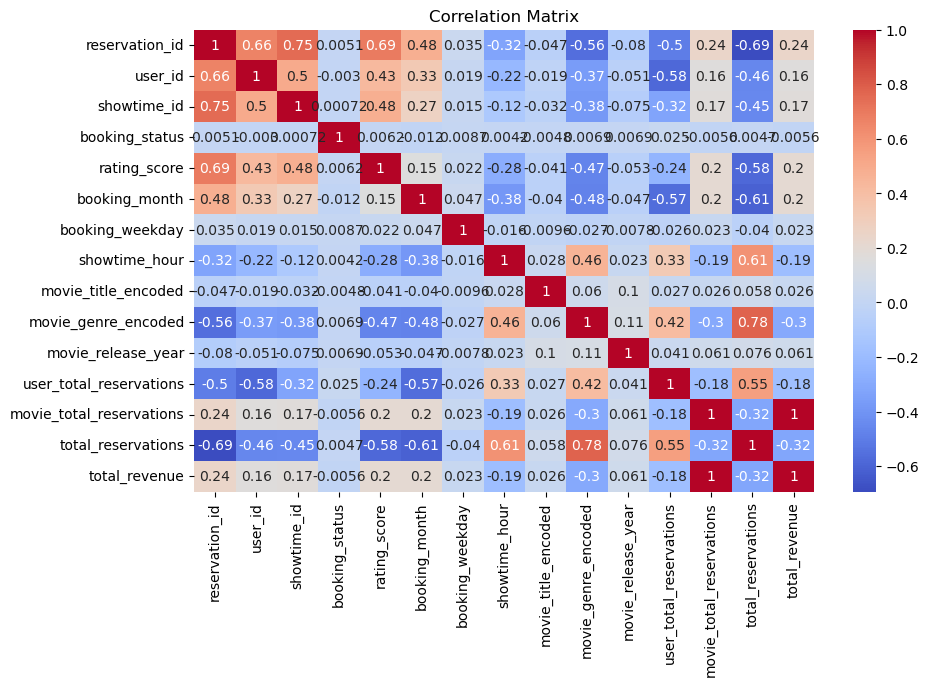

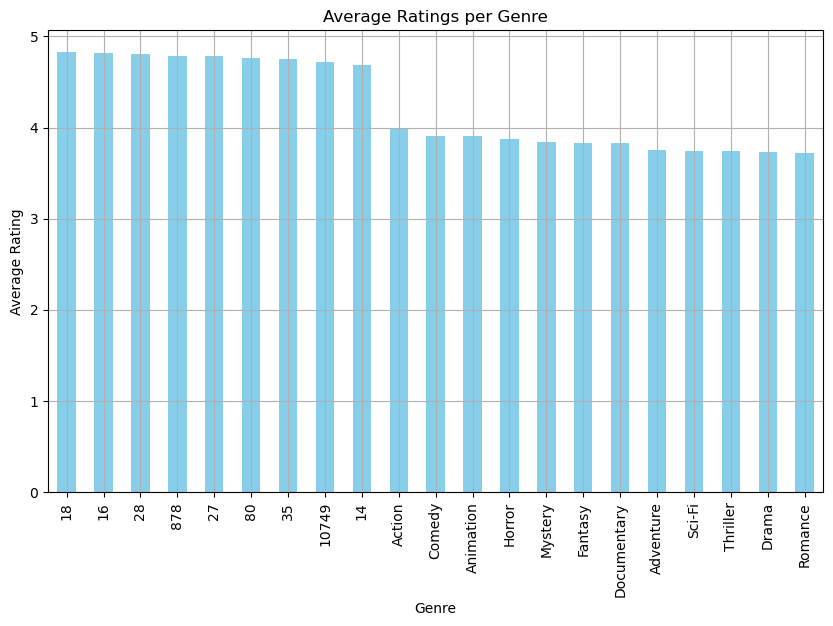

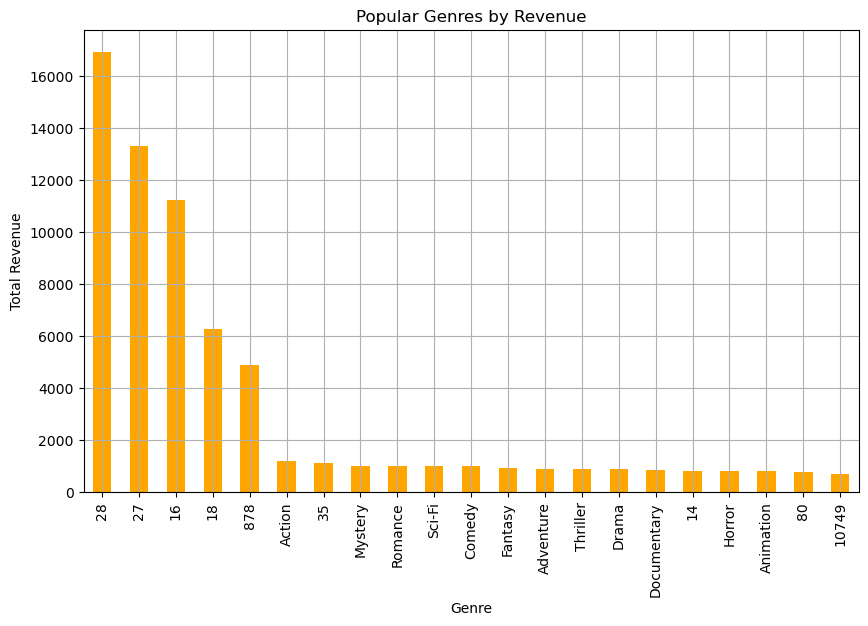

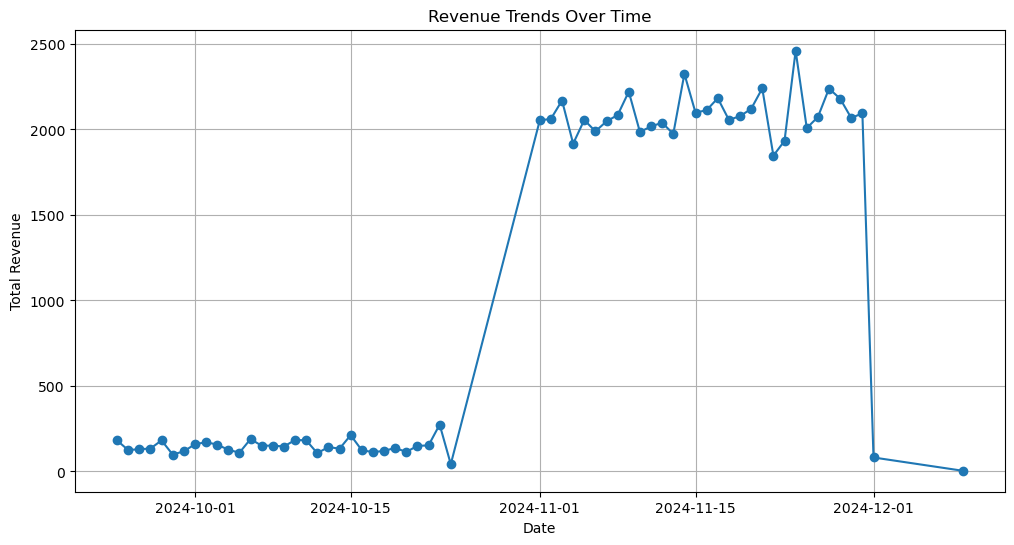

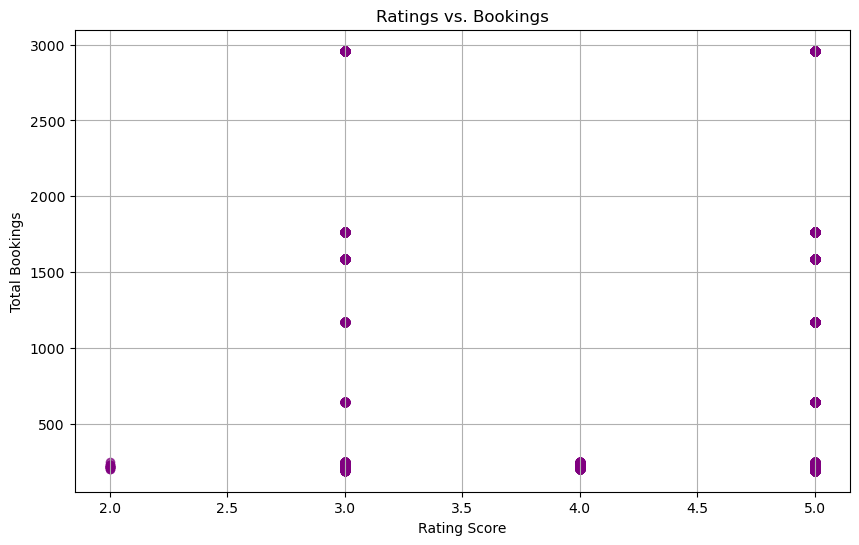

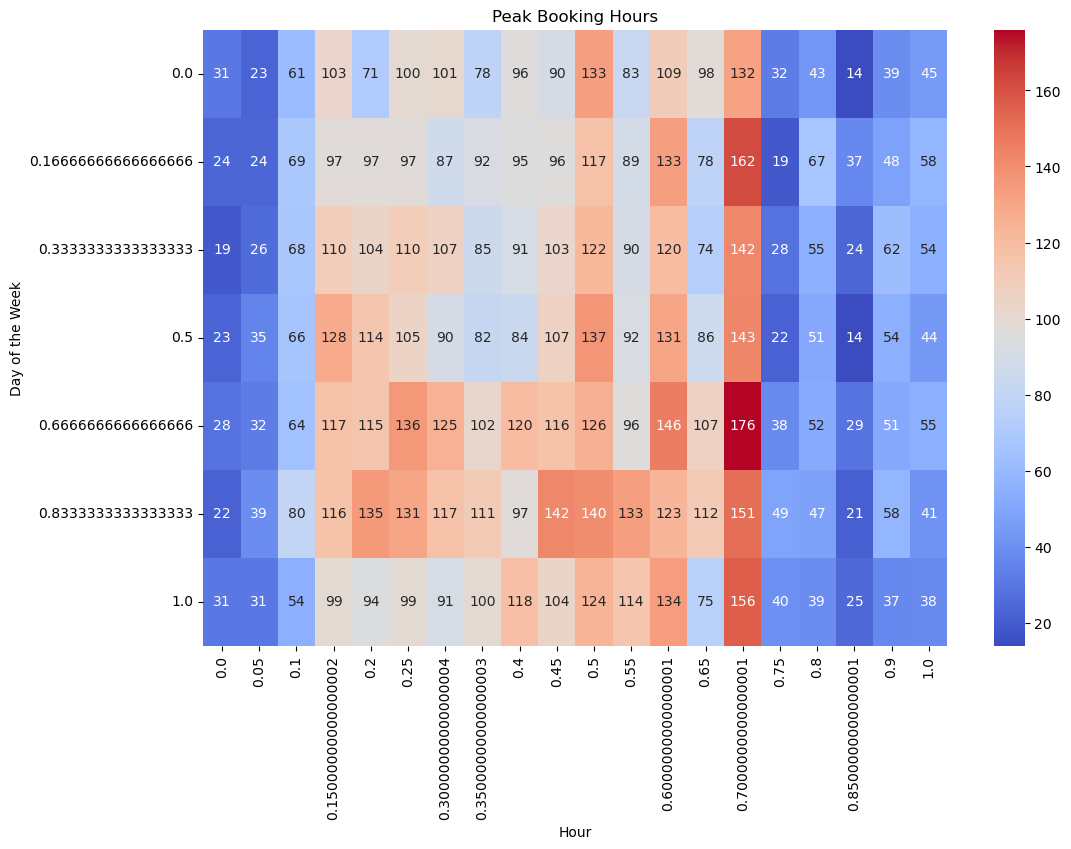

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate total_revenue if missing
if 'total_revenue' not in processed_df.columns:
    processed_df['total_revenue'] = processed_df['movie_total_reservations'] * 10  

# Ensuring required columns exist
required_columns = {'movie_genre', 'rating_score', 'booking_weekday', 'showtime_hour', 'reservation_id', 'total_revenue'}
if not required_columns.issubset(processed_df.columns):
    raise ValueError(f"Some required columns are missing: {required_columns - set(processed_df.columns)}")

# 1. Summary Statistics
# Selecting key statistics for a compact display
compact_summary = processed_df.describe().T[['mean', '50%', 'std', 'min', 'max']]
compact_summary.rename(columns={'50%': 'median'}, inplace=True)

# Display the compact summary
print("Compact Summary Statistics:")
print(compact_summary)

# 2. Correlation Analysis
correlation_matrix = processed_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 3. Average Ratings per Genre
average_ratings = processed_df.groupby('movie_genre')['rating_score'].mean().sort_values(ascending=False)
average_ratings.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Average Ratings per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.grid()
plt.show()

# 4. Popular Genres by Revenue
genre_revenue = processed_df.groupby('movie_genre')['total_revenue'].sum().sort_values(ascending=False)
genre_revenue.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title("Popular Genres by Revenue")
plt.xlabel("Genre")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()

# 5. Line Chart for Revenue Trends
processed_df['booking_date'] = pd.to_datetime(processed_df['booking_date'])
revenue_trends = processed_df.groupby(processed_df['booking_date'].dt.date)['total_revenue'].sum()
revenue_trends.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Revenue Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()

# 6. Scatter Plot for Ratings vs. Bookings
processed_df['total_bookings'] = processed_df.groupby('movie_genre')['reservation_id'].transform('count')
plt.figure(figsize=(10, 6))
plt.scatter(processed_df['rating_score'], processed_df['total_bookings'], alpha=0.7, color='purple')
plt.title("Ratings vs. Bookings")
plt.xlabel("Rating Score")
plt.ylabel("Total Bookings")
plt.grid()
plt.show()

# 7. Peak Booking Hours Heatmap
pivot_data = processed_df.pivot_table(
    index='booking_weekday', 
    columns='showtime_hour', 
    values='reservation_id', 
    aggfunc='count'
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt='d')
plt.title("Peak Booking Hours")
plt.xlabel("Hour")
plt.ylabel("Day of the Week")
plt.show()


